In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import (
    f1_score,
    confusion_matrix,
)

from sklearn.ensemble import (
    ExtraTreesClassifier,
    HistGradientBoostingClassifier,
    VotingClassifier,
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.under_sampling import RandomUnderSampler

In [8]:
RANDOM_STATE = 42
N_SPLITS = 5

In [9]:
# Chargement des données
df_data_train = pd.read_csv("data/train.csv").drop(columns=['Unnamed: 0'])
df_labels_train = pd.read_csv("data/labels.csv").drop(columns=['Unnamed: 0'])


# Fonction de prétraitement
def pretraitement(df_data_train, df_labels_train=None):
    df_data_train_copy = df_data_train.drop(["Age_Group"], axis=1)
    df_data_train_copy["BMI_Category"] = df_data_train_copy["BMI_Category"].map(
        {'Underweight': 0, 'Normal weight': 1, 'Overweight': 3, 'Obese': 5}
    )
    df_data_train_copy["Education_Level"] = df_data_train_copy["Education_Level"].map(
        {'No High School': 0, 'High School Graduate': 3, 'Some College': 4}
    )
    df_data_train_copy["Income_Group"] = df_data_train_copy["Income_Group"].map(
        {"Low Income": 1, "Middle Income": 3, "High Income": 6}
    )

    # Polynomial features
    continuous_features = ["BMI", "MentHlth", "PhysHlth", "Age"]
    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly.fit_transform(df_data_train_copy[continuous_features])

    # Add polynomial features
    poly_feature_names = [
        f"{name}_poly2" if "^2" in name or " " in name else name
        for name in poly.get_feature_names_out(continuous_features)
    ]
    X_poly = pd.DataFrame(
        poly_features, columns=poly_feature_names, index=df_data_train_copy.index
    )
    df_data_train_copy = pd.concat(
        [df_data_train_copy, X_poly.loc[:, poly_feature_names[4:]]], axis=1
    )

    # Clean feature names for LightGBM compatibility
    df_data_train_copy.columns = df_data_train_copy.columns.str.replace(
        "[^A-Za-z0-9_]+", "", regex=True
    )
    df_data_train_copy.fillna(df_data_train_copy.median(), inplace=True)

    if df_labels_train is not None:
        df_labels_train_copy = df_labels_train
        return df_data_train_copy, df_labels_train_copy
    return df_data_train_copy


# Prétraitement
df_data_train_copy, df_labels_train_copy = pretraitement(df_data_train, df_labels_train)

#Split des données
X_train, X_test, y_train, y_test = train_test_split(
    df_data_train_copy,
    df_labels_train_copy,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

# Normalisation
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Undersampling
rus = RandomUnderSampler(sampling_strategy=0.19, random_state=RANDOM_STATE)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)



In [10]:
LGBM_Elie = LGBMClassifier(
    random_state=RANDOM_STATE, force_row_wise=True, class_weight="balanced", verbosity=-1,
    objective="binary", learning_rate=0.05, max_depth=20, n_estimators=500,
    num_leaves=100, subsample=0.5, reg_alpha=1
)

xgb_clf = XGBClassifier(
    scale_pos_weight=3.0, learning_rate=0.1, max_depth=5, n_estimators=200,
    subsample=1.0, eval_metric='logloss', random_state=RANDOM_STATE
)

catboost_clf = CatBoostClassifier(
    class_weights=[1, 2.5], iterations=500, learning_rate=0.1,
    depth=6, random_seed=RANDOM_STATE, eval_metric='Logloss', verbose=0
)

hist_gb_clf = HistGradientBoostingClassifier(
    class_weight='balanced',
    learning_rate=0.1,
    max_iter=200,
    max_depth=5,
    min_samples_leaf=30,
    random_state=RANDOM_STATE
)

extra_trees_clf = ExtraTreesClassifier(
    n_estimators=100, max_depth=None, min_samples_split=2, random_state=RANDOM_STATE,
    class_weight='balanced'
)

# Création de l'ensemble (VotingClassifier)
ensemble_model = VotingClassifier(
    estimators=[
        ('lightgbm', LGBM_Elie),
        ('xgboost', xgb_clf),
        ('catboost', catboost_clf),
        ('hist_gradient_boosting', hist_gb_clf),
        ('extra_trees', extra_trees_clf),         
    ],
    voting='soft',
    weights=[1, 1.95, 2.15, 1.05, 1]
)

ensemble_model.fit(X_resampled, y_resampled.values.ravel())

y_test_pred = ensemble_model.predict(X_test)

print("\nEvaluation de l'ensemble sur l'ensemble de test :")
print(confusion_matrix(y_test, y_test_pred))
print("F1 Score on test:", f1_score(y_test, y_test_pred))


Evaluation de l'ensemble sur l'ensemble de test :
[[29489  5440]
 [ 2260  3400]]
F1 Score on test: 0.4689655172413793


Best Threshold: 0.5040000000000002
Best F1 Score: 0.4699248120300752
Confusion Matrix at Optimal Threshold:
[[29600  5329]
 [ 2285  3375]]


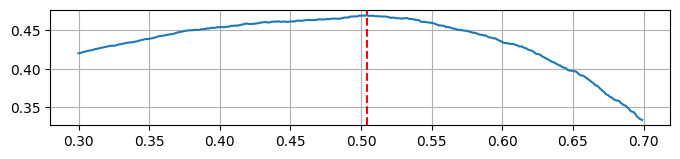

In [11]:
y_test_pred = ensemble_model.predict_proba(X_test)[:, 1]
# Test various thresholds
thresholds = np.arange(0.3, 0.7, 0.001)
f1_scores = [f1_score(y_test, (y_test_pred >= t).astype(int)) for t in thresholds]

# Find the best threshold based on F1 score
best_threshold = thresholds[np.argmax(f1_scores)]
print("Best Threshold:", best_threshold)
print("Best F1 Score:", max(f1_scores))

y_test_pred_optimal = (y_test_pred >= best_threshold).astype(int)

conf_matrix = confusion_matrix(y_test, y_test_pred_optimal)
print("Confusion Matrix at Optimal Threshold:")
print(conf_matrix)

plt.figure(figsize=(8, 1.5))
plt.plot(thresholds, f1_scores)
plt.axvline(x=best_threshold, color='r', linestyle='--')
plt.grid(True)
plt.show()

In [12]:
data_test = pd.read_csv('data/test.csv')

test_index = data_test["Unnamed: 0"]
data_test = data_test.drop(columns=["Unnamed: 0"])

df_data_test_copy = pretraitement(data_test, None)
scaler_test = StandardScaler()

df_data_test_copy = scaler.transform(
    df_data_test_copy
)
y_pred_test_proba = ensemble_model.predict_proba(df_data_test_copy)[:, 1]
y_pred_test = (y_pred_test_proba >= best_threshold).astype(int)

submission = pd.DataFrame({
    "index": test_index,  
    "Diabetes_binary": y_pred_test
})

count_1 = submission["Diabetes_binary"].value_counts().get(1, 0)
total = len(y_pred_test)
ratio_1 = count_1 / total
print(f"Ratio of 1's: {ratio_1:.4f}")

submission.to_csv("soumission.csv", index=False)

Ratio of 1's: 0.2194
